In [2]:
import os
import time

import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torchvision.models import resnet50
from torchvision.io import read_image

# from torch.utils.data import DataLoader, Subset
# from torchvision import transforms
# import torchvision.utils as tvutils

from my_utils import data, models
# from my_utils.utils import save_model, check_accuracy, train
# from my_utils.vis import *

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# life save magic code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"There are {torch.cuda.device_count()} GPUs in total.\nThe first GPU is: {torch.cuda.get_device_properties(0)}")
print(f"Using {device} now!")
print(f"torch version: {torch.__version__}")
if use_cuda:
    print(f"CUDA version: {torch.cuda_version}")

There are 1 GPUs in total.
The first GPU is: _CudaDeviceProperties(name='NVIDIA GeForce RTX 3060 Laptop GPU', major=8, minor=6, total_memory=6143MB, multi_processor_count=30)
Using cuda now!
torch version: 1.10.2+cu113
CUDA version: 11.3


In [5]:
model = resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
target_layers = [model.layer4[-1]]
print(target_layers)

[Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)]


In [25]:
model = models.my_ConvNeXt()
print(model)

my_ConvNeXt(
  (connection_layers): ModuleList(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=32, bias=True)
  )
  (norm_layers): ModuleList(
    (0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): Block(
        (dwconv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
        (norm): BatchNorm2d(8, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
        (pwconv1): Linear(in_features=8, out_features=16, bias=True)
        (act): ReLU()
        (pwconv2): Linear(in_features=16, out_features=8, bias=True)
      )
    )
    (1): Sequential(
      (0): Block

In [26]:
target_layers = [model.stages[-1][0]]
print(target_layers)

[Block(
  (dwconv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
  (norm): BatchNorm2d(32, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
  (pwconv1): Linear(in_features=32, out_features=64, bias=True)
  (act): ReLU()
  (pwconv2): Linear(in_features=64, out_features=32, bias=True)
)]


In [16]:
# load modal weights
load_path = 'saved_models/97_polygen_unfilled_myconvnext_2022_01_21_19_58_50.pt'
checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint["model_paras"])

<All keys matched successfully>

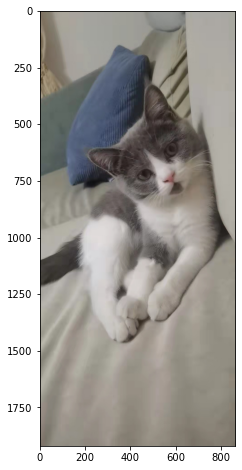

In [32]:
# Create an input tensor image for your model..
img_path = "./examples/my_cat.jpg"
rgb_img = cv2.imread(img_path, 1)[:, :, ::-1] # BGR -> RGB
rgb_img = np.float32(rgb_img) / 255
plt.imshow(rgb_img)
input_tensor = preprocess_image(rgb_img,
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
# Note: input_tensor can be a batch tensor with several images!
# input_tensor = read_image(img_path)
# plt.imshow(input_tensor.permute(1,2,0))

In [65]:
# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.
# e.g. targets = [ClassifierOutputTarget(281)] # cat 281-287
# e.g. targets = [ClassifierOutputTarget(151)] # dog 151-268
# targets = [ClassifierOutputTarget(284)]
targets = None

In [73]:
# Construct the CAM object once, and then re-use it on many images:
with GradCAM(model=model, target_layers=target_layers, use_cuda=use_cuda) as cam:
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

categories: [283]


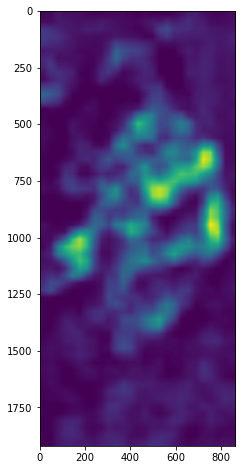

In [74]:
# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
plt.imshow(grayscale_cam)

(-0.5, 863.5, 1919.5, -0.5)

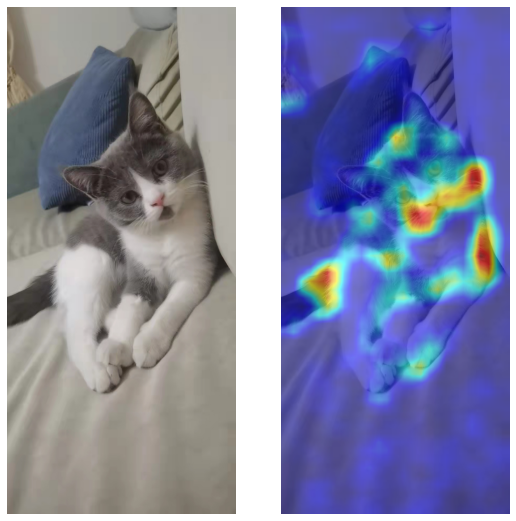

In [75]:
vis_cam = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(9, 10))
plt.subplot(1, 2, 1)
plt.imshow(rgb_img)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(vis_cam)
plt.axis("off")